# Deep Learning &mdash; Assignment 6

Sixth assignment for the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_October 2022_

-----

**Names:** Hauque, Federico Gabriel - Soler Sanz, Guillem

**Group:** 5

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will

1. Implement and train a generative adversarial network.
2. Experiment with reverse gradient training.
3. Implement a CycleGAN.
4. Experiment with CycleGAN optimization.

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with the [Dive into deep learning](https://d2l.ai) book.
* `PIL`, the python image library

All libraries can be installed with `pip install`.

In [ ]:
# render plots as png, not as svg
# (svg is very slow with large scatterplots)
!pip install d2l==1.0.0a1.post0
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
import csv
import glob
import re
from collections import defaultdict
import numpy as np
import scipy
import sklearn.datasets
import matplotlib.pyplot as plt
import PIL
import torch
import torch.autograd
import torchvision
import torchvision.transforms
from d2l import torch as d2l


from IPython import display

device = d2l.try_gpu()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.1 MB/s eta 0:00:00


## 6.1 Moon dataset

The noisy moon dataset is a synthetic dataset with the following distribution:

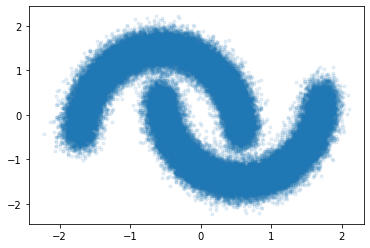

In [ ]:
n_samples = 100000
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.1)
noisy_moons[0][:, 0] -= np.mean(noisy_moons[0][:, 0])
noisy_moons[0][:, 0] /= np.std(noisy_moons[0][:, 0])
noisy_moons[0][:, 1] -= np.mean(noisy_moons[0][:, 1])
noisy_moons[0][:, 1] /= np.std(noisy_moons[0][:, 1])
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], '.', alpha=0.1);

**(a) Run the following code to convert the data to a PyTorch dataset:**

In [ ]:
moon_dataset = torch.utils.data.TensorDataset(torch.tensor(noisy_moons[0], dtype=torch.float32),
                                              torch.tensor(noisy_moons[1], dtype=torch.float32))

## 6.2 Generator

We define a generator that generates samples from a learned distribution, based on a random noise input.

The generator accepts 1D input vector with 100 elements and has to output a 1D vector with 2 elements.

In [ ]:
class MoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.net(x)

**(a) Generate some samples from this generator before training and plot the resulting distribution.**

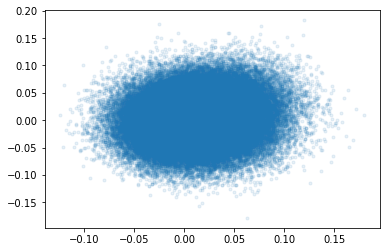

In [ ]:
gen = MoonGenerator()
x = torch.rand((n_samples, 100)) * 2 - 1
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.1);

## 6.3 Untrainable dummy generator network

For our experiments, we also define an untrainable dummy generator network that produces samples from a uniform distribution. We'll use this later to investigate what our discriminator learns.

In [ ]:
class UniformMoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dummy_param = torch.nn.Parameter(torch.tensor([0.]))

    def forward(self, x):
        return torch.rand((x.shape[0], self.output_size),
                          device=x.device, dtype=x.dtype) * 4 - 2

**(a) Run the code to generate some samples from this generator and plot the resulting distribution.**

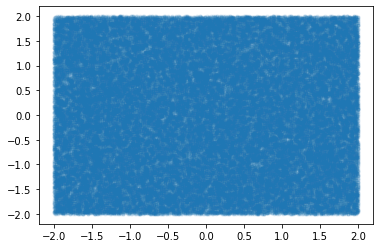

In [ ]:
gen = UniformMoonGenerator()
x = torch.randn((n_samples, 100))
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.1);

## 6.4 Discriminator (1 point)

To train the generator, we need a discriminator that takes the samples from the generator and samples from the real distribution. For real samples, the discriminator should predict 1, for fake samples it should predict 0.

For stability, we will exclude the final sigmoid activation from the discriminator and use the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) function during training.

**(a) Inspect the code for the discriminator below:**

In [ ]:
class MoonDiscriminator(torch.nn.Module):
    def __init__(self, inputs=2, hiddens=1024):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(inputs, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, 1)
        )
        # Note: Although this is a binary classifier, we do not yet apply
        #       a sigmoid activation here. Instead, we'll use the
        #       BCEWithLogitsLoss later to compute sigmoid + BCE loss in
        #       a numerically stable way.

    def forward(self, x):
        return self.net(x)

We can plot the value of the discriminator in our sample space to see what it is doing.

**(b) Run the code to plot the output of an untrained discriminator:**

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


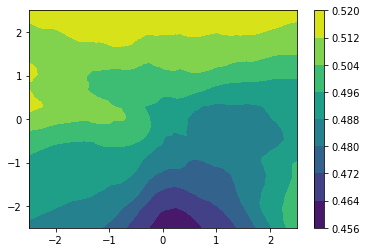

In [ ]:
def plot_discriminator(discriminator, xmin=-2.5, xmax=2.5, steps=500):
    x0, x1 = torch.meshgrid(torch.linspace(xmin, xmax, steps=steps),
                            torch.linspace(xmin, xmax, steps=steps))
    x = torch.stack([x0.flatten(), x1.flatten()], axis=1)
    y = discriminator(x)
    y = torch.sigmoid(y).detach().cpu().numpy()
    y = y.reshape(x0.shape)
    plt.contourf(x0, x1, y)
    plt.colorbar()

disc = MoonDiscriminator()
plot_discriminator(disc)

**(c) How do you expect this plot to look after training the discriminator for the moon dataset?<span style="float:right"> (1 point)</span>**

When you have a trained discriminator, you would like to have only output values of 1 or 0. The shape should probably look like the distribution of the real data, containing 1's in the shape of the moons.

## 6.5 Adversarial training loop (1 point)

Now we have a generator and a discriminator, we can attempt to train the model. We will define a training function that implements the adversarial training procedure:

For each minibatch of real samples:
1. Generate a batch of fake samples;
2. Compute the discriminator loss on the real and fake samples;
3. Optimize the discriminator;
4. Generate another batch of fake samples;
5. Compute the generator loss on the fake samples;
6. Update the generator.

To monitor training, we'll print the discriminator and generator loss. We'll also monitor the accuracy of the discriminator (the percentage of correctly labeled real and fake samples) and the 'accuracy' of the generator (the percentage of fake samples incorrectly labeled as real by the discriminator).

**(a) Complete the training loop below:<span style="float:right"> (1 point)</span>**

In [ ]:
def train_adversarial(generator, discriminator, data_loader, epochs=10,
                      lr_gen=0.001, lr_disc=0.001, device=device):
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen)
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_disc)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        epoch_disc_acc = 0
        epoch_gen_acc = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            ## 1. Discriminator
            # generate noise for the generator
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            # generate fake samples
            x_fake = generator(rand_for_gen)

            # run discriminator on real and fake samples
            d_real = discriminator(x_real)
            d_fake = discriminator(x_fake)

            # compute discriminator loss
            # - for real samples, the discriminator should predict 1
            # - for fake samples, the discriminator should predict 0
            disc_loss = (bce_logits_loss(d_real, torch.ones_like(d_real)) +
                         bce_logits_loss(d_fake, torch.zeros_like(d_fake)))
            disc_acc = (torch.mean((d_real > 0).to(torch.float)) +
                        torch.mean((d_fake < 0).to(torch.float))) / 2

            # update discriminator
            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()


            ## 2. Generator
            # generate another batch of fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # compute generator loss
            d_fake = discriminator(x_fake)
            gen_loss = bce_logits_loss(d_fake, torch.ones_like(d_fake))
            # for the generator, we compute how many generated samples were given
            # the label 'real' by the discriminator
            gen_acc = torch.mean((d_fake > 0).to(torch.float))

            # update generator
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            ## 3. Statistics
            epoch_disc_loss += disc_loss.item()
            epoch_gen_loss += gen_loss.item()
            epoch_disc_acc += disc_acc.item()
            epoch_gen_acc += gen_acc.item()
            mb_count += 1

        print('Epoch %d: disc_loss=%f gen_loss=%f  disc_acc=%f gen_acc=%f' %
              (epoch, epoch_disc_loss / mb_count, epoch_gen_loss / mb_count,
               epoch_disc_acc / mb_count, epoch_gen_acc / mb_count))

## 6.6 Experiment: Train the discriminator only (4 points)

First, we'll train the discriminator only, using the dummy generator to generate samples from a uniform distribution.

**(a) Run the code to train the discriminator:**

In [ ]:
gen = UniformMoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen, disc, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

disc.to('cpu')
gen.to('cpu');

Epoch 0: disc_loss=0.976189 gen_loss=3.046140  disc_acc=0.757798 gen_acc=0.352911
Epoch 1: disc_loss=0.902629 gen_loss=3.640815  disc_acc=0.787654 gen_acc=0.307385
Epoch 2: disc_loss=0.902535 gen_loss=3.747663  disc_acc=0.787194 gen_acc=0.306456
Epoch 3: disc_loss=0.893272 gen_loss=3.785435  disc_acc=0.789247 gen_acc=0.305677
Epoch 4: disc_loss=0.891674 gen_loss=3.770447  disc_acc=0.789447 gen_acc=0.309613
Epoch 5: disc_loss=0.890895 gen_loss=3.801664  disc_acc=0.789797 gen_acc=0.309613
Epoch 6: disc_loss=0.888582 gen_loss=3.817483  disc_acc=0.791550 gen_acc=0.312040
Epoch 7: disc_loss=0.888993 gen_loss=3.873385  disc_acc=0.790531 gen_acc=0.311581
Epoch 8: disc_loss=0.887926 gen_loss=3.892820  disc_acc=0.790786 gen_acc=0.313939
Epoch 9: disc_loss=0.884255 gen_loss=3.932047  disc_acc=0.792344 gen_acc=0.310362


**(b) Plot the discriminator output and inspect the result:<span style="float:right"> (1 point)</span>**

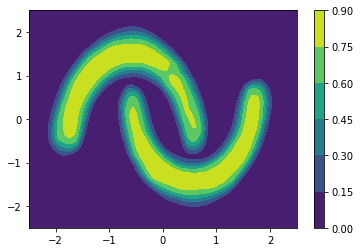

In [ ]:
plot_discriminator(disc)

**(c) Briefly discuss this result. Why does the discriminator learn this?<span style="float:right"> (2 points)</span>**

The discriminator plot has a similar shape to the noisy moon distribution, yet it is a bit thinner, because the outer parts of the moon are the noisier ones, hence the most difficult to train.

**(d) Does the discriminator reach 100% classification accuracy? Why, or why not?<span style="float:right"> (1 point)</span>**

It does not reach it, becuase the generator is somewaht confusing the discriminator with fake inputs.

## 6.7 Experiment: Train the generator and discriminator (9 points)

We'll now train the model with the trainable generator.

**(a) Train the generator and discriminator together:**

In [ ]:
gen = MoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen, disc, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

disc.to('cpu')
gen.to('cpu');

Epoch 0: disc_loss=1.095303 gen_loss=1.304488  disc_acc=0.703425 gen_acc=0.259251
Epoch 1: disc_loss=1.308464 gen_loss=0.871383  disc_acc=0.604050 gen_acc=0.339834
Epoch 2: disc_loss=1.323928 gen_loss=0.814136  disc_acc=0.590668 gen_acc=0.345039
Epoch 3: disc_loss=1.344688 gen_loss=0.776237  disc_acc=0.572041 gen_acc=0.346827
Epoch 4: disc_loss=1.364782 gen_loss=0.734475  disc_acc=0.539967 gen_acc=0.375170
Epoch 5: disc_loss=1.375198 gen_loss=0.713074  disc_acc=0.523532 gen_acc=0.418298
Epoch 6: disc_loss=1.381261 gen_loss=0.705164  disc_acc=0.514576 gen_acc=0.424612
Epoch 7: disc_loss=1.298332 gen_loss=0.902380  disc_acc=0.603576 gen_acc=0.313309
Epoch 8: disc_loss=1.376807 gen_loss=0.721125  disc_acc=0.537304 gen_acc=0.432415
Epoch 9: disc_loss=1.385987 gen_loss=0.704394  disc_acc=0.512058 gen_acc=0.482217


**(b) Run the code below to plot the generated samples, the discriminator output, and the real samples.**

Note: If you don't get a good results, try to run the model again. This model is quite sensitive to the random initialisation.

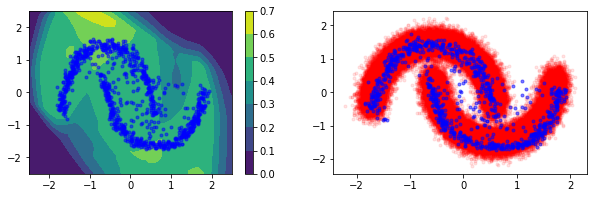

In [ ]:
def plot_generator(generator, n_samples=1000):
    x = torch.rand((n_samples, 100)) * 2 - 1
    y = generator(x).detach().cpu().numpy()
    plt.plot(y[:, 0], y[:, 1], 'b.', alpha=0.5)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plot_discriminator(disc)
plot_generator(gen)
plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.1)
plot_generator(gen)

**(c) Briefly discuss this result.<span style="float:right"> (1 point)</span>**

The discriminator now has a higher loss, while the generator has less. This generator is visibly more capable of tricking the discriminator, hence more successful against its adversary. The discriminator struggles more to distinguish correct examples from fake ones, so the plot is more likely to accept many fake values.

Compare the output of the new discriminator with the output of the discriminator trained without a generator.

**(d) Are the discriminator outputs the same? Why does this happen?<span style="float:right"> (2 points)</span>**

No, the output spans through a bigger area, and this is reasonable because the generator has been more capable of tricking the discriminator with these outputs than with the uniform ones.

**(e) Does the discriminator still reach a high accuracy? Why (not?)<span style="float:right"> (1 point)</span>**

No, the accuraccy is about 35% lower than in the other. It is

**(f) How should we interpret the accuracy for the discriminator and the 'accuracy' for the generator? How can we see if the model is working well?<span style="float:right"> (2 points)</span>**

The discriminator accuracy must be high. But the generator accuracy is just a measure of how many generated elements are considered correct. If the generator haves a very different distribution, accuracy must be very low, but if the distributions is more similar, the accuracy can remain in a not-so-low value, yet it should never be high, and of course not higher than the discriminator.

**(g) Compare the distribution learned by the generator with the real distribution. What are the main differences and why are the distributions different?<span style="float:right"> (2 points)</span>**

The generator learned a distribution that combines the original one with the noise of the fake examples of the generateor. It spans along a region around the mean zero, but gets a bit larger in the upper and lower edges of the moons.

**(h) How can you make the distributions more similar?<span style="float:right"> (1 point)</span>**

We could parametrize the discriminator better, so that is not easily confused with the generator inputs, or simply opt for a more similar distribution in the generator, yet this will turn it into a non-optimal adversary.

## 6.8 Gradient reversal (1 point)

As an alternative to training the discriminator and generator separately, we can also train the model with a gradient reversal layer that reverses the gradient coming from the discriminator:

```
Forward: generator -> discriminator.
Backward: generator gradient <- gradient reversal <- discriminator gradient.
```

In PyTorch, we'll implement this as a function `revgrad(x)` that will reverse the gradient that passes through it. You can use it like this:
```
y = discriminator(revgrad(generator(x)))
loss = loss_fn(y, target)
loss.backward()
```

**(a) Run the code to define the `revgrad` gradient reversal function:**

In [ ]:
class RevGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_): 
        ctx.save_for_backward(input_)
        output = input_
        return output

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = None
        if ctx.needs_input_grad[0]:
            grad_input = -grad_output
        return grad_input

revgrad = RevGrad.apply

The training loop is now a bit simpler than before, because we do not have to compute the generator loss separately.

**(b) Complete the new training function:<span style="float:right"> (1 point)</span>**

In [ ]:
def train_adversarial_revgrad(generator, discriminator, data_loader, epochs=10, lr=0.001, device=device):
    parameters = list(generator.parameters()) + list(discriminator.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc_real = 0
        epoch_acc_fake = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            # generate fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # run discriminator on real and random samples,
            # reverse the gradient for the generator
            d_real = discriminator(x_real)
            d_fake = discriminator(revgrad(x_fake))


            # compute loss
            loss_real = bce_logits_loss(d_real, torch.ones_like(d_real))
            loss_fake = bce_logits_loss(d_fake, torch.zeros_like(d_fake))
            loss = loss_real + loss_fake

            # compute discriminator accuracy
            acc_real = torch.mean((d_real > 0).to(torch.float))
            acc_fake = torch.mean((d_fake < 0).to(torch.float))

            # update generator and discriminator
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_loss += loss.item()
            epoch_acc_real += acc_real.item()
            epoch_acc_fake += acc_fake.item()
            mb_count += 1

        print('Epoch %d: loss=%f  acc_real=%f acc_fake=%f' %
              (epoch, epoch_loss / mb_count,
               epoch_acc_real / mb_count, epoch_acc_fake / mb_count))

## 6.9 Experiment: Training with gradient reversal (3 points)

**(a) Train a generator and discriminator with the new training function:**

In [ ]:
gen = MoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial_revgrad(gen, disc, loader, epochs=10, lr=0.001, device=device)

disc.to('cpu')
gen.to('cpu');

Epoch 0: loss=1.009206  acc_real=0.763147 acc_fake=0.733116
Epoch 1: loss=1.181591  acc_real=0.711207 acc_fake=0.629666
Epoch 2: loss=1.267702  acc_real=0.635410 acc_fake=0.609145
Epoch 3: loss=1.348602  acc_real=0.556076 acc_fake=0.555497
Epoch 4: loss=1.376791  acc_real=0.594150 acc_fake=0.457261
Epoch 5: loss=1.322991  acc_real=0.621943 acc_fake=0.502078
Epoch 6: loss=1.382935  acc_real=0.529672 acc_fake=0.501149
Epoch 7: loss=1.384655  acc_real=0.534697 acc_fake=0.478061
Epoch 8: loss=1.324392  acc_real=0.596507 acc_fake=0.540721
Epoch 9: loss=1.384436  acc_real=0.538643 acc_fake=0.495115


**(b) Plot and inspect the results:**

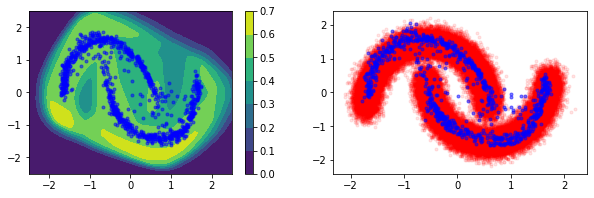

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plot_discriminator(disc)
plot_generator(gen)

plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.1)
plot_generator(gen)

**(c) Briefly discuss the result.<span style="float:right"> (1 point)</span>**

The trainning takes less epochs to get close to it's final place. The generated points and the discriminator performance seem very comparable to the two-steo approach

**(d) What are some advantages and disadvantages of the gradient reversal layer, compared with the previous two-step approach?<span style="float:right"> (2 points)</span>**

If generation of fake samples is computationally expensive, you need to reduce it, since both models are optimized with the same samples. Furthermore, using the gradient from the discriminator in the generator  allows it to more directly learn from the discriminator. That could be an advantage because it allows a faster learning. On the other hand, could be a disadvantage because the learned information is less general.

## 6.10 Emoji dataset

For the second part of this assignment we will borrow an emoji dataset (and some ideas) from a course at the [University of Toronto](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/).

The dataset contains images of Apple-style and Windows-style emojis. You can [download the files](http://www.cs.toronto.edu/~jba/emojis.tar.gz) yourself or use the code below.

**(a) Download the dataset and extract the files:**

In [ ]:
 !wget -c http://www.cs.toronto.edu/~jba/emojis.tar.gz
 !tar xzf emojis.tar.gz

--2023-03-23 17:02:12--  http://www.cs.toronto.edu/~jba/emojis.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5933583 (5.7M) [application/x-gzip]
Saving to: ‘emojis.tar.gz’

emojis.tar.gz       100%[===================>]   5.66M  4.25MB/s    in 1.3s    

2023-03-23 17:02:14 (4.25 MB/s) - ‘emojis.tar.gz’ saved [5933583/5933583]



We'll resize the images to 32 by 32 pixels and normalize the RGB intensities to values between -1 and 1.

**(b) Run the code to construct the datasets:**

In [ ]:
def image_loader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGBA')[0:3, :, :]

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

d_windows = torchvision.datasets.ImageFolder('emojis/Windows/', transform)
d_apple = torchvision.datasets.ImageFolder('emojis/Apple/', transform)

**(c) Plot a few images to see the different styles:**

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


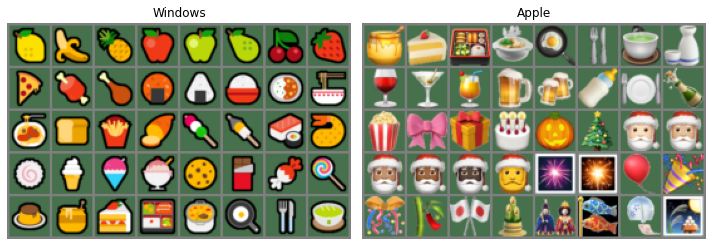

In [ ]:
def image_grid(d, idxs):
    images = [d[idx][0] for idx in idxs]
    grid = torchvision.utils.make_grid(images)
    return grid.numpy().transpose(1, 2, 0) / 2 + 0.5

# Depending on the PyTorch version, this code might print
# a warning about transparency. This is not a problem.

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_grid(d_windows, range(100, 140)))
plt.title('Windows')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_grid(d_apple, range(400, 440)))
plt.title('Apple')
plt.axis('off')
plt.tight_layout()

## 6.11 CycleGAN (2 points)

We'll try to train a CycleGAN that can translate emojis between the Windows and Apple styles.

This CycleGAN has the following components:
* A generator that translates from Windows to Apple;
* A generator that translates from Apple to Windows;
* A discriminator that discriminates between real and fake emojis from the Windows distribution;
* A discriminator that discriminates between real and fake emojis from the Apple distribution.

### Generator

First, we define the generator. We'll use the same generator architecture for both directions. Unlike before, the generator does not take random noise as input, but expects a 32 by 32 RGB image as input and returns a 32 by 32 RGB image as output.

The generator has the following structure:
```
- Input: 32x32 pixels, 3 channels.
- Two downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 32 -> 64 channels.
- One convolution block in the middle:
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 64 channels.
- Two upsampling + convolution blocks:
  upsampling (scale factor 2) followed by convolution,
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 32 -> 3 channels.
- Output: 32x32 pixels, 3 channels.
```

Add batch normalization and ReLU after each convolution, except at the end.

The images have a [-1, +1] range, so the last output should use a tanh activation without BN.

**(a) Complete the code below:<span style="float:right"> (2 points)</span>**

In [19]:
class CycleGenerator(torch.nn.Module):
    def __init__(self, input_size=100):
        super().__init__()
        self.input_size = input_size
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 pixels
            torch.nn.Conv2d(3, 16, (5, 5), stride=2, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 64, (5, 5), stride=2, padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),

            # no downsampling, no upsampling
            torch.nn.Conv2d(64, 64, (5, 5), padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            # upsampling 8 -> 16 -> 32 pixels
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(64, 32, (5, 5), stride=1, padding=2),
            
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(32, 3, (5, 5), stride=1, padding=2),
            torch.nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

# the output should have the same shape as the input
CycleGenerator()(torch.zeros((30, 3, 32, 32))).shape

torch.Size([30, 3, 32, 32])

### Discriminator

The discriminator is similar in concept to what we had in the GAN model: it takes an image and predicts 1 for a real image and 0 for a fake.

```
- Input: 32x32 pixels, 3 channels.
- Three downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 64 -> 64 -> 64 channels.
- One fully connected layer from (64*4*4) to 1.
- Output: 1 output element.
```

Add batch normalization and ReLU after each convolution, except at the end of the network.

**(b) Read through the code below:**

In [20]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 -> 4
            torch.nn.Conv2d(3, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            
            torch.nn.Linear(64 * 4 * 4, 1)
        )
        # Note: Although this is a binary classifier, we do not apply
        #       a sigmoid activation here. We'll optimize a mean-squared
        #       error to make the discriminator's task a bit harder and
        #       get a slightly better gradient.

    def forward(self, x):
        return self.net(x)

# the output shape should be (30, 1)
Discriminator()(torch.zeros((30, 3, 32, 32))).shape

torch.Size([30, 1])

## 6.12 CycleGAN training loop (2 points)

The training loop for the GAN with cycle-consistency loss follows the following procedure:

For each batch of samples from domain A and B:
* Use the generators to predict the fake B given A, and fake A given B.
* Use the generators to reconstruct A given fake B, and B given fake A.

The discriminator loss is composed of:
* The discriminator losses for real samples from A and B.
* The discriminator losses for fake samples from A and B.

The cycle-consistency loss is composed of:
* The reconstruction loss comparing the real A with the cycled A->B->A.
* The reconstruction loss comparing the real B with the cycled B->A->B.

Finally, the two groups losses are combined with a weight `lambda_cycle` for the cycle-consistency loss:

```loss = discriminator_loss + lambda_cycle * cycle-consistency loss```

**(a) Complete the code below to implement this procedure:<span style="float:right"> (2 points)</span>**

In [21]:
def train_cycle(generator_ab, generator_ba, discriminator_a, discriminator_b,
                data_loader_a, data_loader_b,
                epochs=10, lr=0.001, lambda_cycle=0.1, device=device):
    mse_loss = torch.nn.MSELoss()
    models = torch.nn.ModuleList([generator_ab, generator_ba, discriminator_a, discriminator_b])
    optimizer = torch.optim.Adam(models.parameters(), lr=lr, betas=(0.5, 0.999))
    
    plt.figure(figsize=(10, 15))

    for epoch in range(epochs):
        epoch_stats = defaultdict(lambda: 0)
        mb_count = 0

        disc_a.train()
        disc_b.train()
        gen_ab.train()
        gen_ba.train()

        for (real_a, _), (real_b, _) in zip(loader_a, loader_b):
            real_a = real_a.to(device)
            real_b = real_b.to(device)

            # compute fake images A->B->A
            fake_ab = generator_ab(real_a)
            cycle_aba = generator_ba(fake_ab)

            # compute fake images B->A->B
            fake_ba = generator_ba(real_b)
            cycle_bab = generator_ab(fake_ba)

            # run discriminator on real and fake images
            d_real_a = discriminator_a(real_a)
            d_real_b = discriminator_b(real_b)
            d_fake_ba = discriminator_a(fake_ba)
            d_fake_ab = discriminator_b(fake_ab)

            # compute discriminator loss
            # we optimize the MSE loss function to make the gradients of
            # the discriminator a bit easier to use
            loss_real_a = mse_loss(d_real_a, torch.ones_like(d_real_a))
            loss_real_b = mse_loss(d_real_b, torch.ones_like(d_real_b))
            loss_fake_a = mse_loss(d_fake_ab, torch.ones_like(d_fake_ab))
            loss_fake_b = mse_loss(d_fake_ba, torch.ones_like(d_fake_ba))

            # compute cycle-consistency loss
            loss_cycle_a = mse_loss(cycle_aba, real_a)
            loss_cycle_b = mse_loss(cycle_bab, real_b)

            # compute loss
            loss = loss_real_a + loss_real_b + \
                   loss_fake_a + loss_fake_b + \
                   lambda_cycle * (loss_cycle_a + loss_cycle_b)

            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_stats['loss'] += loss.item()
            epoch_stats['loss_real_a'] += loss_real_a.item()
            epoch_stats['loss_real_b'] += loss_real_b.item()
            epoch_stats['loss_fake_a'] += loss_fake_a.item()
            epoch_stats['loss_fake_b'] += loss_fake_b.item()
            epoch_stats['loss_cycle_a'] += loss_cycle_a.item()
            epoch_stats['loss_cycle_b'] += loss_cycle_b.item()
            mb_count += 1

        if epoch % 5 == 0:
            print('Epoch %d: ' % epoch, end='')
            for k, v in epoch_stats.items():
                print(' %s=%6.4f' % (k, v / mb_count), end='')

            images_for_plot = {
                'real_a': real_a, 'fake_ab': fake_ab, 'cycle_aba': cycle_aba,
                'real_b': real_b, 'fake_ba': fake_ba, 'cycle_bab': cycle_bab,
            }

            for k in range(10):
                for i, (im_title, im) in enumerate(images_for_plot.items()):
                    plt.subplot(10, 6, k * 6 + i + 1)
                    plt.imshow(im[k].detach().cpu().numpy().transpose(1, 2, 0) / 2 + 0.5)
                    if k == 0:
                        plt.title(im_title)
                    plt.axis('off')
            plt.tight_layout()
            display.display(plt.gcf())
            display.clear_output(wait=True)

## 6.13 Experiment: CycleGAN training (6 points)

We can now train our CycleGAN model.

**(a) Run the code below and play with the hyperparameters if necessary to learn a reasonable output.**

Note that GANs can be notoriously difficult to train, so don't worry if your results are not perfect. Hopefully, you will be able to get somewhat recognizable results, but it's more important that you can interpret and discuss what happens.

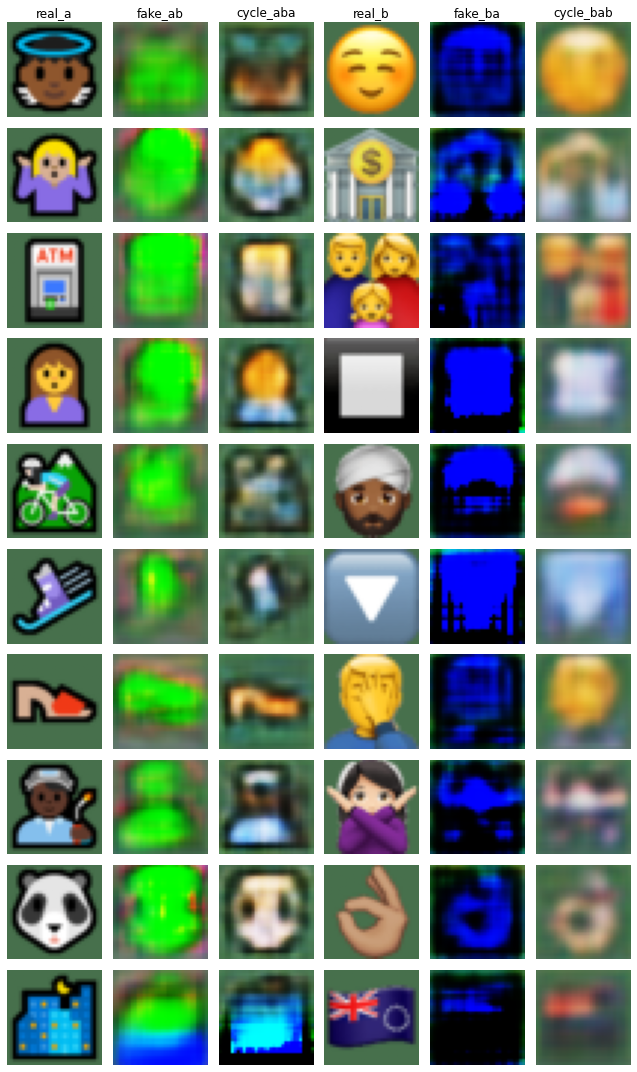

In [ ]:
import warnings
warnings.filterwarnings("ignore")
gen_ab = CycleGenerator().to(device)
gen_ba = CycleGenerator().to(device)
disc_a = Discriminator().to(device)
disc_b = Discriminator().to(device)

loader_a = torch.utils.data.DataLoader(d_windows, batch_size=32, shuffle=True, num_workers=4)
loader_b = torch.utils.data.DataLoader(d_apple, batch_size=32, shuffle=True, num_workers=4)

train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=1, device=device)

**(b) Run some more experiments to study the effect of the lambda_cycle weight.<span style="float:right"> (1 point)</span>**

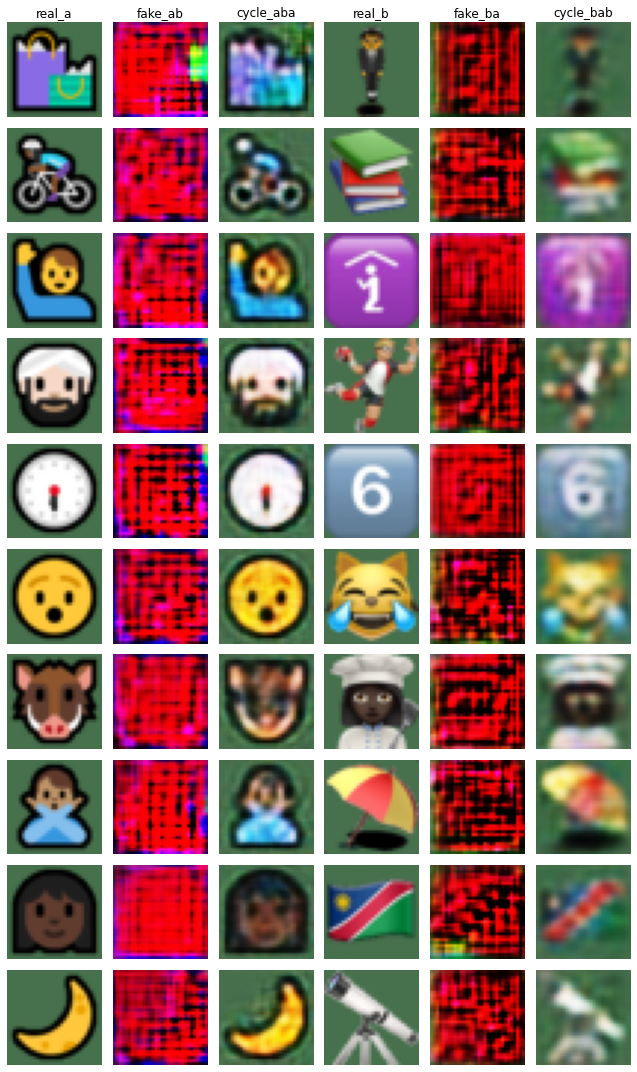

In [ ]:
train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=3, device=device)

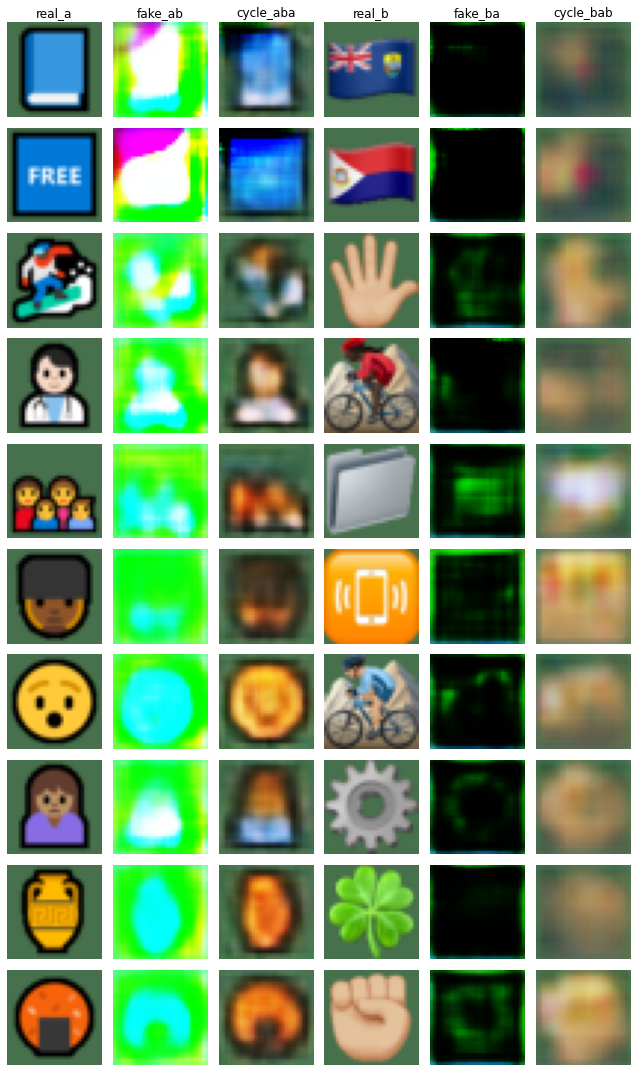

In [ ]:
train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=0.1, device=device)

**(c) Discuss your results and training experience. Was the model easy to train? What do you think of the results? Does it learn a good translation between Windows and Apple emojis?<span style="float:right"> (2 points)</span>**

The model doesn't seem to learn a good translation between Windows and Apple Emoji's at all. The direct fakes never come close to a good result and also seems to improve very slowly. However , it quickly learns a consistent reconstruction.

**(d) What is the effect of the lambda_cycle weight? What happens if you set it to a very large value? What happens if you set it to 0? Can you explain this?<span style="float:right"> (2 points)</span>**

Lamba cycle weight is used to weigh the contribution of the loss of cycle consistency in relation to the adversarial loss towards the loss used for model updates.

If we set the value very low, the model does not learn to reconstruct the original input. Instead that, if we set the value high, the model learns to reconstruct the original input very well.

**(e) Why is the reconstructed output (A->B->A or B->A->B) usually better than the translated output (A->B or B->A)?<span style="float:right"> (1 point)</span>**

The original input contains the information to get a good reconstruction, but it's way harder to find a good translation to the other emoji type. Therefore, the model initially just learns to encode it's input information in the fake, in a way that the reconstruction is able to reverse it. This is why most fakes look like the original input, but with shifted colours.

## 6.14 Final questions (4 points)

**(a) Discuss how the balance between the generator and discriminator affects GAN training. What can go wrong if one part is better or learns more quickly than the other?<span style="float:right"> (2 points)</span>**

Ideally the generator and discriminator both improve at a similar rate. If for instance the discriminator becomes too good too quickly, the generator may end up not improving much at all anymore. On the other hand, if the discriminator cannot catch up with the generator improvements, then the predictions are going to be awful.

**(b) CycleGAN and similar methods are unsupervised models that learn to map inputs from one domain to another. Does this mapping necessarily preserve the semantics of the images? Why, or why not?<span style="float:right"> (1 point)</span>**
<br>(For example, think about how our emoji model would translate flags.)

Not necessarily. Taking the example of flag translation, the model would learn to map a flag in the windows set to the Apple set in a way where it would resemble a Apple emoji, but that doesn't mean that the colours have to match the colours from the original input.

**(c) Have a brief look at [CycleGAN, a Master of Steganography](https://arxiv.org/pdf/1712.02950.pdf), a paper published at NIPS 2017. The authors show that a CycleGAN network sometimes 'hides' information in the generated images, to help with the reconstruction. Can you see something like this in your results as well?<span style="float:right"> (1 point)</span>**

It is impressive how some very simple generated images can actaully reconstruct so similar emojis. This is indeed happening, especially in those generated files with very high or low lambda cycles, where the generated file barely resembles the original picture, but the cycle reconstruction manages to get a somehow similar drawing.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 33 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version a8afc98 / 2022-10-11</span>